# Geographical-based friendship network<!-- omit in toc-->

Luca Di Bello, University of Italian Switzerland (USI), 2023

## Table of contents<!-- omit in toc-->

- [Project description](#project-description)
- [Inhabitant maps](#inhabitant-maps)
  - [Purely random map](#purely-random-map)
  - [Geographical-based random map](#geographical-based-random-map)
  - [Friendship network](#friendship-network)

## Project description

Social networks are systems that map the relationships and interactions between individuals. Although social networks are typically dynamic, the focus of this project is put on a static example.

Geographical distance plays a crucial role in social network formation, with closer physical proximity typically leading to more frequent and stronger social ties.

Additionally, geographical features, such as the density of people in an area (more in cities and less in remote mountainous regions), profoundly influence the composition and scale of these networks, shaping the diversity and connectivity of communities within a given region.

## Inhabitant maps

The project features two kinds of inhabitant maps:

### Purely random map

1000 inhabitants are randomly distributed across a unit square map, $[0,1]^2$. Each individual is assigned a uniform random position $(x,y)$ in the map.

### Geographical-based random map

This map features several geographical areas $F$, such as cities, mountains, and lakes. The inhabitants are randomly distributed across the map, but the density of inhabitants is higher in cities and lower in mountains and lakes. The function $f$ maps the coordinates $(x, y)$ of an individual to the geographical area $f$ in which the individual is located.

$$
f(x,y) = \text{geographical area in which individual } (x,y) \text{ is located}
$$

In this map, individuals are no longer distributed uniformly at random across the map. Instead, the density of inhabitants depends on specific geographical features: each area has a positive factor that determines the ease of living there:

$$
s_f = \text{ease of living in area } f \ \forall f \in F
$$

The probability of a random individual being located in coordinates $(x,y)$ is the following:

$$
P(\text{random person settles in } (x,y)) = \frac{s_{f(x,y)}}{\sum_{(x',y') \in \text{Map}} s_{f(x',y')}}
$$

## Friendship network

$$
\textcolor{red}{\textbf{FINISH THIS WHEN I HAVE SOME TIME}}
$$


## Implementation


In [2]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import seaborn as sns

> **Note:** The code documentation follows the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html).


### Scenario 1


#### A - Design for the random inhabitant map and friendship network

In this section will be defined useful functions, needed to accomplish next parts of the project

$\textcolor{red}{\textbf{FIX THIS DESCRIPTION WITH CHATGPT}}$


##### A.1 - Sampling individuals

The function `sample_uniform_random_individuals` samples $n$ individuals randomly from a unit square map $[0,1]^2$.

Pseudocode:

```
function sample_uniform_random_individuals(n):
    individuals <- []
    for each individual i = 1,2,....n:
        x <- Uniform(0,1)
        y <- Uniform(0,1)
        individuals <- individuals UNION {(x,y)}
    end for
    return individuals
end function
```


In [3]:
def sample_uniform_random_individuals(n=1000) -> np.ndarray:
  """
  Randomly sample n individuals from a uniform distribution.

  Args:
    n (int): Number of individuals to sample

  Returns:
    np.array: Array of tuples containing x and y coordinates of sampled individuals
  """
  # Generate n uniform random numbers for x and y coordinates
  x = np.random.uniform(0,1,size=n)
  y = np.random.uniform(0,1,size=n)

  # Save invididual coordinates as a tuple
  return np.array(list(zip(x, y)))

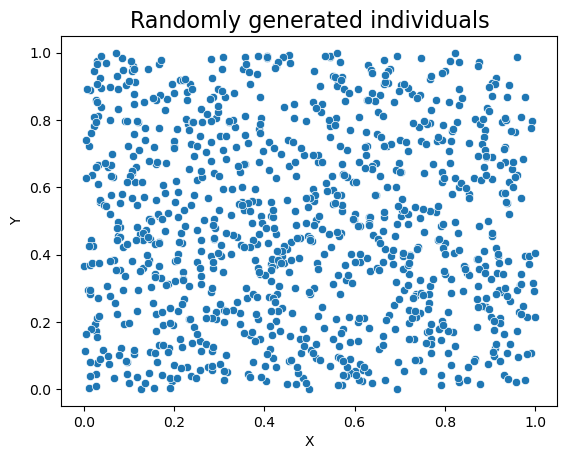

In [4]:
# Convert list to numpy array
individuals = sample_uniform_random_individuals()

# Print the first 10 individuals
fig = sns.scatterplot(x = individuals[:, 0], y = individuals[:, 1])
fig.set_title('Randomly generated individuals').set_fontsize('16')
fig.set_xlabel('X')
fig.set_ylabel('Y')

# Show the plot
plt.show()

##### A.2 - The `euclDistMatrix` function

The function `euclDistMatrix` computes the Euclidean distance between all pairs of individuals in a given map. The Euclidean distance between two individuals $i$ and $j$ is defined as follows:

$$
d(i,j) = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}
$$

Pseudocode:

```
function euclDistMatrix(individuals):
    distMatrix <- NxN matrix of zeros (where N = |individuals|)
    for each individual i in individuals:
        for each individual j in individuals:
            distMatrix[i,j] <- sqrt((x_i - x_j)^2 + (y_i - y_j)^2)
        end for
    end for
    return distMatrix
end function
```


In [5]:
def euclDistMatrix(individuals: np.ndarray) -> np.ndarray:
  '''
  Creates a n x n matrix of Euclidean distances between n individuals

  Args:
    individuals (np.ndarray): Array of tuples containing x and y coordinates of individuals

  Returns:
    np.ndarray: n x n matrix of Euclidean distances between n individuals
  '''

  # Create an empty n x n matrix
  distMatrix = np.zeros((individuals.shape[0], individuals.shape[0]))

  # Loop over all individuals
  for i in range(individuals.shape[0]):
    # Loop over all individuals again
    for j in range(individuals.shape[0]):
      if i == j:
        continue # Distance between individual i and itself is 0 so we can skip this iteration
      else:
        # Calculate Euclidean distance between individual i and j
        distMatrix[i, j] = np.sqrt((individuals[i][0] - individuals[j][0])**2 + (individuals[i][1] - individuals[j][1])**2)
  return distMatrix

##### A.3 - The `distMatrixFromN` function

The function `distMatrixFromN`, given a number $n$ of individuals, performs the following steps 100 times:

1. Sample $n$ individuals randomly from a unit square map $[0,1]^2$.
2. Compute the Euclidean distance between all pairs of individuals in the map.
3. Computes summary information for the distance matrix such as the minimum, maximum, mean, median, and standard deviation of the distances.

For each of the summary statistics, the function returns a list of 100 values.

Pseudocode:

```
function distMatrixFromN(n)
    # Empty vectors to store statistics
    minDistances <- []
    maxDistances <- []
    meanDistances <- []
    medianDistances <- []
    stdDistances <- []

    # Execute 100 simulations
    for i in {1,2,...,100}:
        # Sample n individuals function defined in point A.1
        individuals <- sample_uniform_random_individuals(n)
        distMatrix <- euclDistMatrix(individuals)
        minDistances <- minDistances UNION {min(distMatrix)}
        maxDistances <- maxDistances UNION {max(distMatrix)}
        meanDistances <- meanDistances UNION {mean(distMatrix)}
        medianDistances <- medianDistances UNION {median(distMatrix)}
        stdDistances <- stdDistances UNION {std(distMatrix)}
    end for
    return minDistances, maxDistances, meanDistances, medianDistances, stdDistances
end function
```


In [6]:
def distMatrixFromN(n: int) -> pd.DataFrame:
  '''
  This function simulates 100 times the generation of n individuals and
  computes the minimum, maximum, mean, median and standard deviation of the distances on each of them.

  Args:
    n (int): Number of individuals to sample per simulation.

  Returns:
    pd.DataFrame: DataFrame containing 100 rows, each of them contains the computed statistics.
  '''

  # Empty list to store statistics
  minDistances = np.zeros(100)
  maxDistances = np.zeros(100)
  meanDistances = np.zeros(100)
  medianDistances = np.zeros(100)
  stdDistances = np.zeros(100)

  # Run the experiment 100 times
  for i in range(100):
    # Sample N individuals
    individuals = sample_uniform_random_individuals(n)
    # Compute distances between sampled individuals
    distMatrix = euclDistMatrix(individuals)

    # Compute + save statistics
    minDistances[i] = np.min(distMatrix[distMatrix > 0])
    maxDistances[i] = np.max(distMatrix[distMatrix > 0])
    meanDistances[i] = np.mean(distMatrix[distMatrix > 0])
    medianDistances[i] = np.median(distMatrix[distMatrix > 0])
    stdDistances[i] = np.std(distMatrix[distMatrix > 0])

  # Create pandas DataFrame
  return pd.DataFrame({'minDistances': minDistances, 'maxDistances': maxDistances, 'meanDistances': meanDistances, 'medianDistances': medianDistances, 'stdDistances': stdDistances})

distMatrixFromN(10)

,minDistances,maxDistances,meanDistances,medianDistances,stdDistances
0,0.029271,0.993467,0.525445,0.607214,0.261655
1,0.048702,1.072598,0.538631,0.526007,0.291582
2,0.071240,1.064300,0.455976,0.415007,0.248740
3,0.015217,0.836437,0.407346,0.424015,0.222129
4,0.059225,0.999747,0.495080,0.487222,0.229763
...,...,...,...,...,...
95,0.104640,1.152878,0.602085,0.606817,0.263301
96,0.013375,0.963895,0.533183,0.545983,0.237458
97,0.089757,0.959181,0.525357,0.540160,0.228552
98,0.017133,1.218619,0.555954,0.558083,0.254629


##### A.4 - The `erdosRenyiFromP` function

The function `erdosRenyiFromP` generates an Erdos-Renyí graph given the number of individuals $n$ and the probability $p$ of an edge between a couple of nodes.

Pseudocode:

```
function erdosRenyiFromP(n, p)
  adjency_matrix = N x N matrix of zeros (where N = n)

  # Cycle through each individual
  for individual i in {1,2,...n}
    for individual j in {i+1,i+2,...,n-1}
      # Bernoulli simulation with probability p of positive outcome (having an edge between i and j)
      if (uniform(0,1) < p)
        # Since the graph is undirected we need to set the edge between i and j and between j and i
        adjacency_matrix[i, j] = 1
        adjacency_matrix[j, i] = 1
      end if
    end for
  end for

  # Return adjency matrix
  return adjency_matrix

end function
```


#### B - Exploring alternative modeling approaches

#### B.1 - Exploring n

In this section will be explored the minimum, maximum and mean Euclidean distance on a randomly generated population of size $n$, analyzing the data with different sizes: 10, 100, 1000, 10000.

The simulations will be run using function `distMatrixFromN` defined earlier in point A.3 to simulate 100 times the Euclidean distance between all pairs of individuals in a given map thus having 100 values for each of the summary statistics with the objective of having a more robust analysis.


Running simulation for n = 10
	-took 0.06615710258483887 seconds
Running simulation for n = 30
	-took 0.4273099899291992 seconds
Running simulation for n = 50
	-took 0.8953289985656738 seconds
Running simulation for n = 100
	-took 3.7126808166503906 seconds
Running simulation for n = 500
	-took 92.28180193901062 seconds


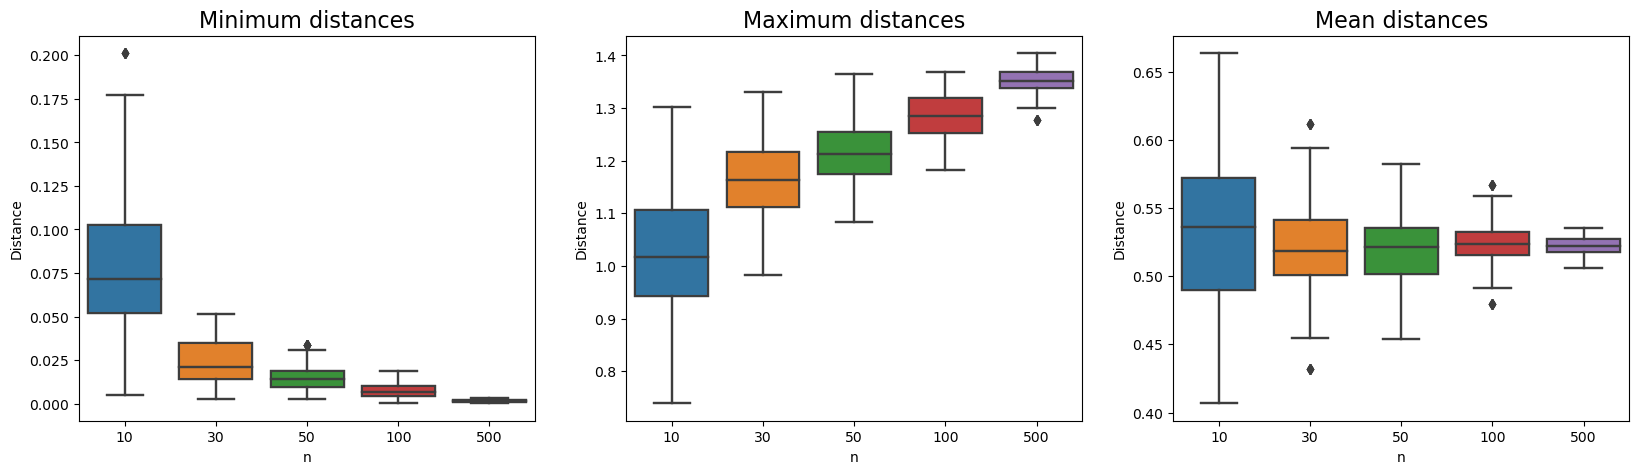

In [7]:
import time
# ns = [1,10,100,1000,10000]
ns = [10,30,50,100,500]

# Run simulations with different sizes
results: list[pd.DataFrame] = []
for n in ns:
  print("Running simulation for n = {}".format(n))
  # Save start time
  start = time.time()
  result = distMatrixFromN(n)
  print("\t-took {} seconds".format(time.time() - start))

  # Compute simulation + save result
  results.append(result)

# Extract min, max, mean distances from results
minDistances = [result['minDistances'].values for result in results]
maxDistances = [result['maxDistances'].values for result in results]
meanDistances = [result['meanDistances'].values for result in results]

# Plot min, max, mean distances
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

def plotBoxplotDistances(ax, distances, ns, title):
  # Plot min distances as boxplot
  for _ in range(len(ns)):
    sns.boxplot(distances, ax=ax)
    ax.set_title(title).set_fontsize('16')
    ax.set_xlabel('n')
    ax.set_ylabel('Distance')
  # Update ticks to show n values
  ax.set_xticklabels(ns)

# Plot min / max / mean distances distances
plotBoxplotDistances(ax[0], minDistances, ns, 'Minimum distances')
plotBoxplotDistances(ax[1], maxDistances, ns, 'Maximum distances')
plotBoxplotDistances(ax[2], meanDistances, ns, 'Mean distances')

From the generated plots, it is possible to note the following trends:

- The minimum distance tends to decrease when $n$ increases. This behavior is expected, as the probability of having points closer to each other is proportional to the number of uniformly generated samples.

- The maximum distance tends to increase when $n$ increases. For the same reasons as above, the probability of two points being far from each other increases. The maximum distance will tend to $\sqrt{2}$, as the maximum distance between two points in a unit square is the diagonal of the square.

- The average distance tends to decrease when $n$ increases. Also, this behavior is expected, as the population density increases, the average distance between two points decreases.


#### B.2 - Exploring p

In this section will be explored characteristics of the Erdos-Renyi graph generated with probabilities $p$ of an edge between a couple of nodes, analyzing the data with different values of $p$: 0.1, 0.2, 0.3, 0.4, 0.5.


In [8]:
# Generate random graph
ps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9]

# Run simulations with different sizes
graphs = [(p, ig.Graph.Erdos_Renyi(n=1000, p=p, directed=False, loops=False)) for p in ps]

##### Degree distribution

In this section will be explored the degree distribution of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.


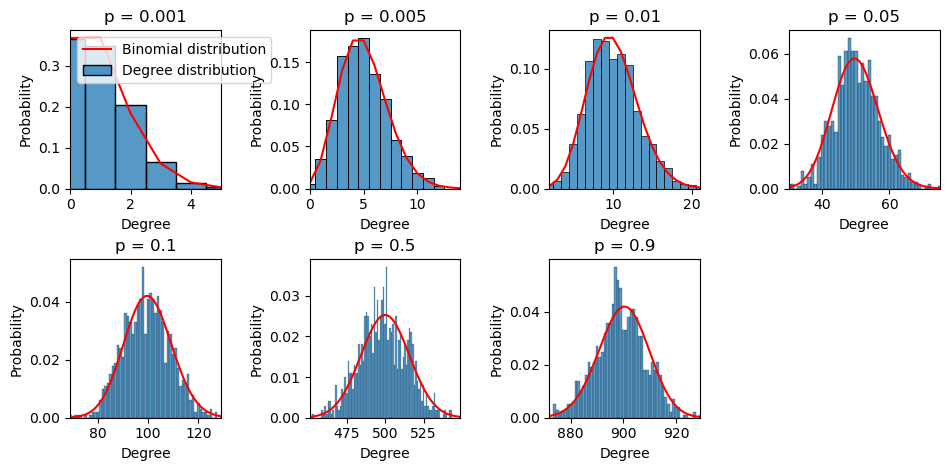

In [151]:
from scipy import stats

# Plot degree distribution
nrows = 2
ncols = 4
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# Add space between subplots
fig.tight_layout(pad=3.0)

# Compute degree distribution for each p
prob_degrees = []
for p in ps:
  prob_degrees.append(stats.binom.pmf(np.arange(0, 1000), n=1000, p=p))

for i, tuple in enumerate(graphs):
  p, graph = tuple
  ax = axs[i//4, i%4]
  degrees = graph.degree()
  series = pd.Series(degrees)

  # Plot degree distribution as histogram
  sns.histplot(series, label='Degree distribution', ax=ax, stat='probability', discrete=True)
  
  # Plot binomial distribution on top of histogram
  ax.plot(np.arange(0, 1000), prob_degrees[i], label='Binomial distribution', color='red')

  # Zoom in on x axis
  ax.set_xlim(min(degrees), max(degrees))

  # Vertical offset to avoid overlapping
  ax.set_title('p = {}'.format(ps[i]))
  ax.set_xlabel('Degree')
  ax.set_ylabel('Probability')

# Hide extra subplots
for i in range(len(ps), nrows * ncols):
  axs[i//4, i%4].axis('off')

# Show legend for all subplots
axs[0, 0].legend()

# Plot figure
plt.show()

From the histogram of the degree distribution (see figure below), it is possible to note that, the more the probability $p$ of having an edge between two nodes increases.

It is possible to see that the degree distribution follows a Binomial distribution, as expected from the Erdos-Renyi model.

##### Adajency matrix structure and average path length

In this section the adajency matrices of a randomly generated population of size $n=1000$ will be explored, analyzing its structure with different probabilities.


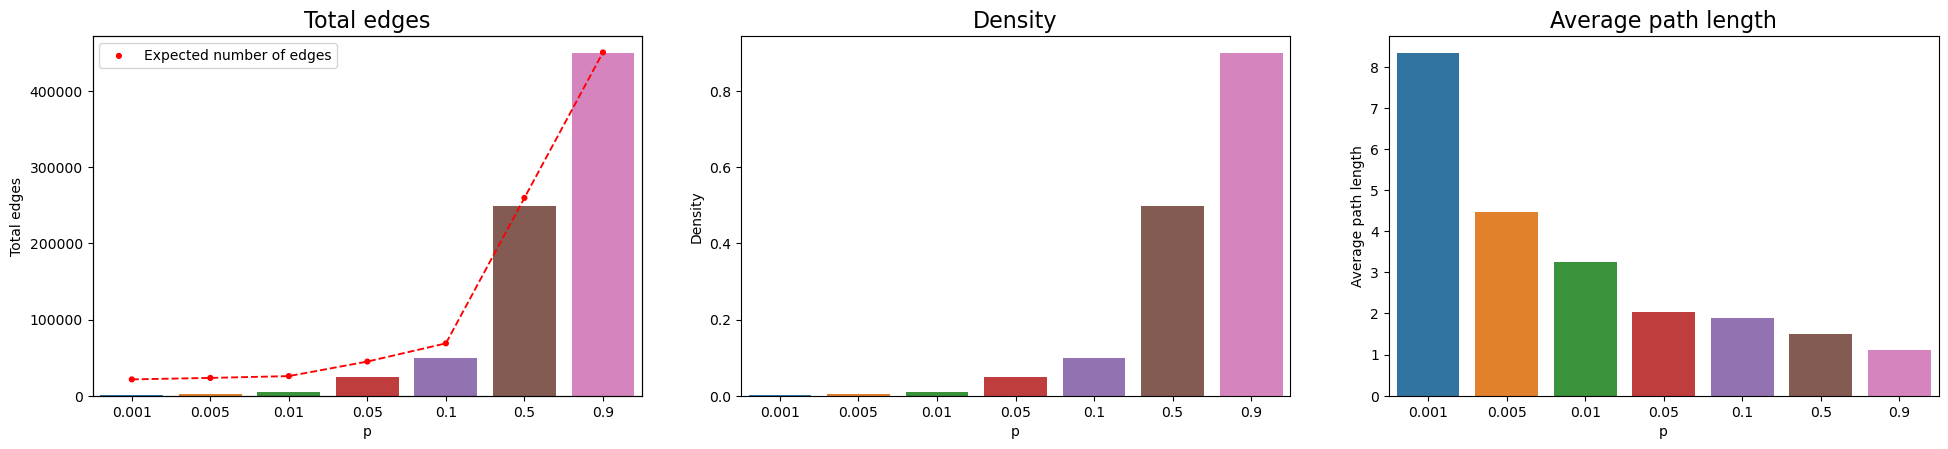

In [81]:
def expectedNumberOfEdges(n: int, p: float) -> float:
  '''
  Computes the expected number of edges in a random graph with n nodes and p probability of edge creation.

  Args:
    n (int): Number of nodes
    p (float): Probability of edge creation

  Returns:
    float: Expected number of edges in a random graph with n nodes and p probability of edge creation
  '''
  return n * (n - 1) / 2 * p

# Create pandas DataFrame
df = pd.DataFrame([
  {
    'p': p,
    'total_edges': graph.ecount(),
    'density': graph.density(),
    'average_degree': np.mean(graph.degree()),
    'average_path_length': graph.average_path_length()
  } for p, graph in graphs])

# Plot total edges, density and average degree
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Add space between subplots
fig.tight_layout(pad=4.0)

def plotHistogram(ax, data, title):
  # Plot histogram
  sns.barplot(x='p', y=data, data=df, ax=ax)
  ax.set_title(title).set_fontsize('16')
  ax.set_xlabel('p')
  ax.set_ylabel(title)

# Plot histograms for total edges on top of expected number of edges
plotHistogram(ax[0], 'total_edges', 'Total edges')
# Plot line and treat X axis as categorical (same scale as barplot)
twin = ax[0].twinx()
twin.set_yticks([])
sns.pointplot(x='p', y=[expectedNumberOfEdges(1000, p) for p in ps], data=df, ax=twin, color='red', linestyles='--', scale=0.5, label='Expected number of edges')
twin.legend(loc='upper left')

# Plot histograms for density
plotHistogram(ax[1], 'density', 'Density')

# Plot histograms for average path length
plotHistogram(ax[2], 'average_path_length', 'Average path length')

# Show figure
plt.show()

From the three graphs above, it is possible to note that, the more the probability $p$ of having an edge between two nodes increases, the more the graph tends to be connected, leading to a more dense adjacency matrix and an higher total number of edges.

It is also possible to note that the average path length tends to decrease when $p$ increases, as the graph tends to be more connected, meaning that the average distance between two nodes becomes smaller. This behavior is expected, as the density of the graph increases, each node will have more neighbors, leading to a smaller average distance between two nodes.

Is possible to see that when $p \rightarrow 1$ the average path length tends to 1, as the graph tends to be fully connected, meaning that each node will have a direct connection with all the other nodes, leading to an average distance of 1.

##### Eigenvalues and degrees

In this section will be explored the relationship between eigenvalues and degrees of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.

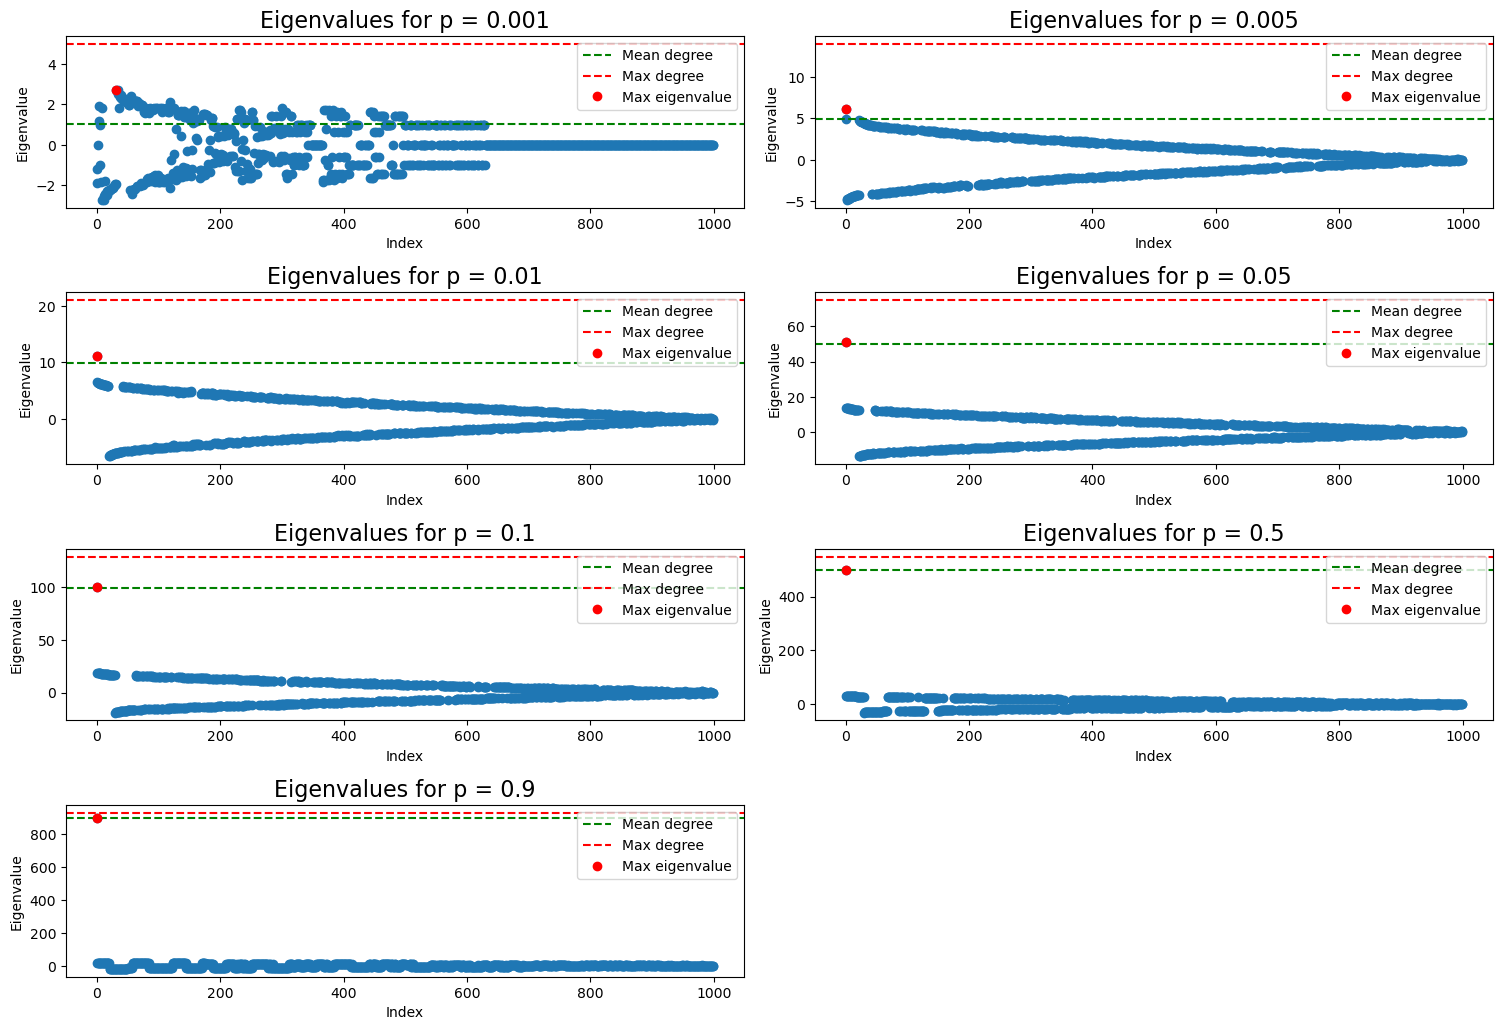

In [124]:
# Create subplots for eigenvalues + add space between subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
fig.tight_layout(h_pad=4.0, w_pad=2.0)

# Loop over graphs
for i, tuple in enumerate(graphs):
  # Unpack tuple
  p, graph = tuple

  # Compute eigenvalues and eigenvectors
  eigenvalues, eigenvectors = np.linalg.eig(graph.get_adjacency().data)

  # Take only real part of eigenvalues
  eigenvalues = eigenvalues.real

  # Find mean and max degree
  degrees = np.array(graph.degree())
  mean_degree = degrees.mean()
  max_degree = degrees.max()

  # Plot eigenvalues
  ax = axes[i//2, i%2]
  ax.plot(eigenvalues, 'o')
  ax.set_title('Eigenvalues for p = {}'.format(p)).set_fontsize(16)
  ax.set_xlabel('Index')
  ax.set_ylabel('Eigenvalue')

  # Add horizontal lines for mean and max degree
  ax.axhline(mean_degree, color='green', linestyle='--', label='Mean degree')
  ax.axhline(max_degree, color='red', linestyle='--', label='Max degree')

  # Highligh max eigenvalue marker with red color
  max_eigenvalue = eigenvalues.max()
  ax.plot(np.where(eigenvalues == max_eigenvalue)[0], max_eigenvalue, 'o', color='red', label='Max eigenvalue')

  # Show legend on upper right corner
  ax.legend(loc='upper right')

# Hide extra subplots
for i in range(len(ps), nrows * ncols):
  axes[i//2, i%2].axis('off')

# Show figure
plt.show()

From the plots above, is possible to note that the maximum eigenvalue is always greater than the average degree, and less than the maximum degree.

##### Largest connected component and eigenvalues

In this section will be explored the relationship between the largest connected component and the eigenvalus of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.

From the Laplacian matrix of the graph, computed as $L = D - A$ where $D$ is the degree matrix and $A$ is the adjacency matrix, it is possible to acquire relevant information about the graph. In particular:

- The number of connected components in a graph equals the number of orthonormal eigenvectors associated with eigenvalue $\lambda = 0$ of the graph Laplacian.

- From the second smallest eigenvalue $\lambda_1$ of the Laplacian matrix of the graph, it is possible to estimate the size of the largest connected component of the graph:
- If $\lambda_1 <= 0$, then the graph is not fully connected, meaning that the largest connected component of the graph is smaller than the entire graph.
- If $\lambda_1 > 0$, the graph is fully connected, meaning that the largest connected component of the graph is the entire graph.

Sources:
- [The Smallest Eigenvalues of a Graph Laplacian (by Shriphani Palakodety)](http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/)
- [Matrices and Graphs – Spectral Techniques](https://courses.cs.duke.edu/fall18/compsci531/lablectures)

p = 0.001
	- Expected number of connected components = 486
	- Actual number of connected components = 486
	- Second smallest eigenvalue = (-9.832656949751888e-16+0j)
	- Size of largest connected component = 108
p = 0.005
	- Expected number of connected components = 6
	- Actual number of connected components = 6
	- Second smallest eigenvalue = 0.0
	- Size of largest connected component = 995
p = 0.01
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 1.5541331870977735
	- Size of largest connected component = 1000
p = 0.05
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 28.13649044912973
	- Size of largest connected component = 1000
p = 0.1
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 66.49789387685381
	- Size of largest connected component = 1000
p = 0.5
	- Expe

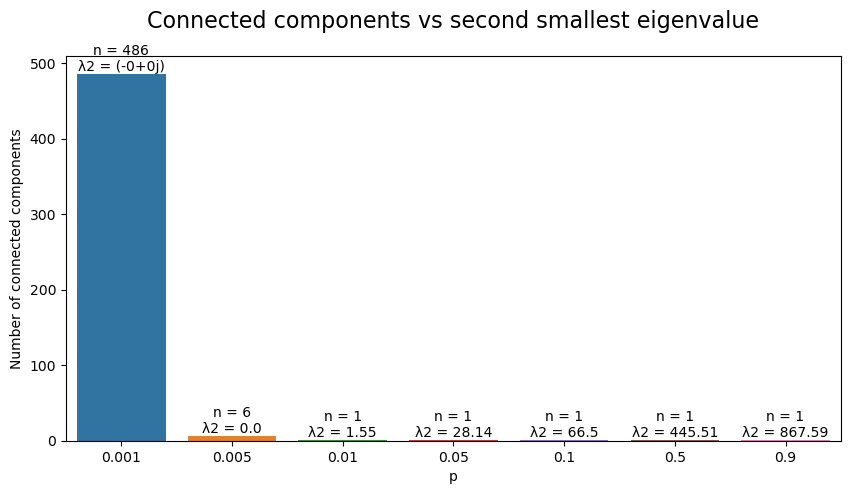

In [211]:
# Create subplots for eigenvalues + add space between subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

n_connected_components = []
n_second_smallest_eigenvalues = []
for i, tuple in enumerate(graphs):
  p, graph = tuple

  # Compute laplacian matrix
  laplacian = graph.laplacian()
  # Compute eigenvalues and eigenvectors of laplacian matrix
  eigenvalues, eigenvectors = np.linalg.eig(laplacian)

  # Compute graph components
  components = graph.components()

  # Compute the total number of orthonormal eigenvectors associated with eigenvalue 0
  num_zero_eigenvectors = np.sum(np.isclose(eigenvalues, 0))
  print("p = {}".format(p))
  print("\t- Expected number of connected components = {}".format(num_zero_eigenvectors))
  print("\t- Actual number of connected components = {}".format(len(components)))

  # Find largest connected component of graph
  largest_component = components.giant()
  # Find the second smallest eigenvalue (Theorem: Fiedler vector)
  second_smallest_eigenvalue = np.sort(eigenvalues)[1]

  # Add data to lists
  n_connected_components.append(len(components))
  n_second_smallest_eigenvalues.append(second_smallest_eigenvalue)

  print("\t- Second smallest eigenvalue = {}".format(second_smallest_eigenvalue))
  print("\t- Size of largest connected component = {}".format(largest_component.vcount()))

# Hide extra subplots
for i in range(len(ps), nrows * ncols):
  axes[i//2, i%2].axis('off')

# Plot number of connected components
fig = sns.barplot(x=ps, y=n_connected_components)
fig.set_title('Connected components vs second smallest eigenvalue', pad=20).set_fontsize('16')
fig.set_xlabel('p')
fig.set_ylabel('Number of connected components')
# Set spacing between title and plot
fig.title.set_position([.5, 1.05])

# Add text showing the number of connected components + second smallest eigenvalue
for i, p in enumerate(ps):
  fig.text(i, n_connected_components[i], 'n = {}\nλ2 = {}'.format(n_connected_components[i], np.round(n_second_smallest_eigenvalues[i], 2)), ha='center', va='bottom')

# Plot
# Increase spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

#### C - Regarding the ErdosRenyiFromP function for generating Friendship Networks

##### C.1 - Erdos-Renyi model to real-world friend networks

Unfortunately, the Erdos-Renyi model is not suitable for modeling real-world friendship networks, as it takes into account only the probability of having an edge between two nodes, without considering the degree of the nodes (the number of friends of a person).

This model in fact, is not able to capture the fact that in real-world friendship networks, the degree of a node is not random, but it follows a power-law distribution, meaning that there are few nodes with a high degree and many nodes with a low degree. This behavior is not captured by the Erdos-Renyi model, as it assumes that the degree of a node is random.

##### C.2 - Advantages and disadvantages of the Erdos-Renyi model

To model a friendship network, the Erdos-Renyi model has the following advantages and disadvantages:

$\textcolor{red}{\textbf{NEED TO CONTINUE FROM HERE}}$

### Scenario 2
